In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/foodguard/ExpireRecognitionModule/Code Files/

/content/drive/.shortcut-targets-by-id/1nR0A33sSPku-x94bP5EhFErbjTaVYorM/foodguard/ExpireRecognitionModule/Code Files


In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
from datetime import datetime, date

In [ ]:

IMAGE_PATH = '/content/drive/MyDrive/foodguard/data/expdate/Date-Real/img_00003.jpg'


TESS_CONFIG = r'--oem 3 --psm 7'

In [ ]:
def check_expiration(raw_date_text):
    """
    Attempts to parse the raw text into a date object and check if it's expired.
    Returns: status (str), parsed_date_str (str or None), day_difference (int or None)
    """
    date_formats = [
        ("%d-%m-%Y", "DD-MM-YYYY"), # Format to match the default whitelist
        ("%m-%y", "MM-YY"),
        ("%d/%m/%Y", "DD/MM/YYYY"),
        ("%m/%d/%Y", "MM/DD/YYYY"),
        ("%d.%m.%y", "DD.MM.YY"),
        ("%Y/%m/%d", "YYYY/MM/DD"),
    ]

    today = date.today()
    parsed_date = None

    for fmt, name in date_formats:
        try:
            # Clean up common date delimiters (Tesseract often outputs -)
            clean_text = raw_date_text.replace('.', '/').replace('-', '/').replace(',', '/').strip()

            # Attempt to parse
            date_obj = datetime.strptime(clean_text, fmt).date()

            # Year correction heuristic for 2-digit years
            if date_obj.year < today.year - 20 and date_obj.year < 2000:
                date_obj = date_obj.replace(year=date_obj.year + 100)

            parsed_date = date_obj
            break
        except (ValueError, TypeError):
            continue

    if parsed_date:
        # Calculate the difference in days
        delta = parsed_date - today
        day_difference = delta.days

        if parsed_date < today:
            # Expired: day_difference will be negative. Return the positive value
            return "EXPIRED", parsed_date.strftime("%Y-%m-%d"), abs(day_difference)
        else:
            # Fresh: day_difference will be non-negative.
            return "FRESH", parsed_date.strftime("%Y-%m-%d"), day_difference
    else:
        # Date not found
        return "DATE NOT FOUND", None, None
# --- END OF NEW FUNCTION ---


In [ ]:
def run_optimized_raw_ocr(image_path):
    print("--- 1. Testing Optimized Raw OCR ---")
    img = cv2.imread(image_path)
    if img is None:
        print("ERROR: Image not found.")
        return

    new_width = img.shape[1] * 10
    new_height = img.shape[0] * 10
    scaled_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    print("Input Image (Scaled 10x):")
    cv2_imshow(scaled_img)

    text = pytesseract.image_to_string(scaled_img, config=TESS_CONFIG)
    print(f"RESULT: '{text.strip()}'\n")

In [ ]:
def run_optimized_kmeans_ocr(image_path):
    print("--- 2. Testing Optimized K-Means Clustering OCR ---")
    img = cv2.imread(image_path)
    if img is None:
        print("ERROR: Image not found.")
        return

    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(image_2D)

    cluster_centers = kmeans.cluster_centers_
    brightness = np.sum(cluster_centers, axis=1)

    text_cluster_index = np.argmin(brightness)

    labels = kmeans.labels_.reshape(img.shape[:2])

    binary_mask = np.full(labels.shape, 255, dtype=np.uint8)

    binary_mask[labels == text_cluster_index] = 0

    print("Processed K-Means Image (Binary Mask):")
    cv2_imshow(binary_mask)

    text = pytesseract.image_to_string(binary_mask, config=TESS_CONFIG)
    print(f"RESULT: '{text.strip()}'\n")
    # --- ADDED: Check Expiration ---
    date_text = text.strip()
    status, parsed_date, days = check_expiration(date_text)

    print("\n--- EXPIRATION CHECK ---")
    if status == "FRESH":
        print(f"Status: FRESH! Expires in {days} days on {parsed_date}.")
    elif status == "EXPIRED":
        print(f"Status: EXPIRED! Expired {days} days ago on {parsed_date}.")
    else:
        print(f"Status: {status}. Could not parse a valid date from '{date_text}'")
    print("------------------------\n")

    print(f"RESULT: '{date_text}'\n")

In [ ]:
def run_optimized_classic_ocr(image_path):
    print("--- 3. Testing Optimized Classic Filter Pipeline OCR ---")

    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print("ERROR: Image not found.")
        return

    new_width = img_gray.shape[1] * 10
    new_height = img_gray.shape[0] * 10
    scaled_img = cv2.resize(img_gray, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    blurred = cv2.GaussianBlur(scaled_img, (5,5), 10.0)
    sharpened_img = cv2.addWeighted(scaled_img, 2.0, blurred, -1.0, 0)

    (thresh, processed_img) = cv2.threshold(
        sharpened_img,
        128,  # This value is ignored because of THRESH_OTSU
        255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )

    print("Processed Classic Pipeline Image (Otsu's Threshold):")
    cv2_imshow(processed_img)

    text = pytesseract.image_to_string(processed_img, config=TESS_CONFIG)
    print(f"RESULT: '{text.strip()}'\n")

In [ ]:

!pip install easyocr

In [ ]:
import easyocr
import cv2
from google.colab.patches import cv2_imshow
def run_morphological_ocr(image_path):
    print("--- 4. Testing Morphological + Whitelist ---")

    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None: return

    scaled_img = cv2.resize(img_gray, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)

    binary_img = cv2.threshold(scaled_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    processed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)

    print("Processed Image (This is the perfect image):")
    cv2_imshow(processed_img)

    custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789-'

    text = pytesseract.image_to_string(processed_img, config=custom_config)
    print(f"RESULT: '{text.strip()}'\n")

In [ ]:
def run_adaptive_threshold_ocr(image_path):
    print("--- 5. Testing Bilateral Filter (Edge-Preserving) ---")

    img = cv2.imread(image_path)
    if img is None: return

    scaled_img = cv2.resize(img, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)

    denoised_img = cv2.bilateralFilter(scaled_img, 9, 75, 75)

    gray_img = cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY)

    processed_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    print("Processed Image (Bilateral Filter + Otsu):")
    cv2_imshow(processed_img)

    text = pytesseract.image_to_string(processed_img, config=TESS_CONFIG)
    print(f"RESULT: '{text.strip()}'\n")

--- 1. Testing Optimized Raw OCR ---
Input Image (Scaled 10x):


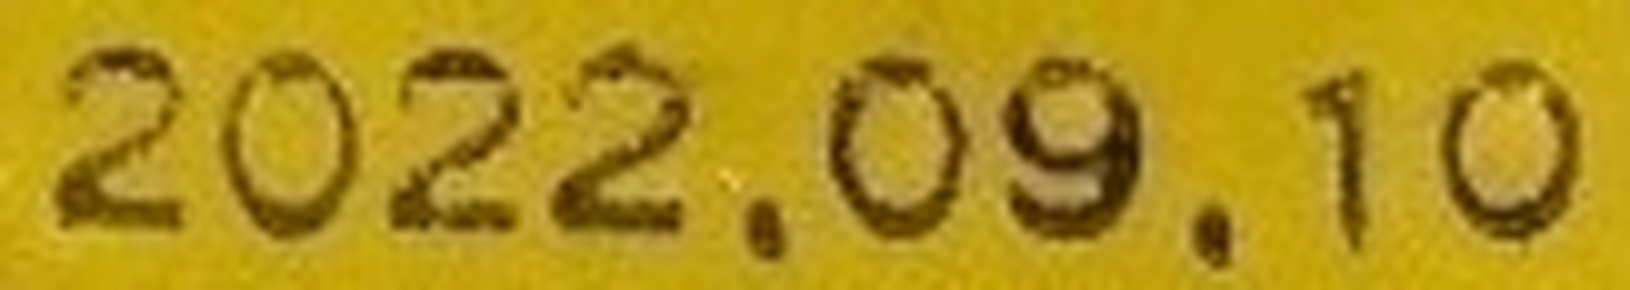

RESULT: '2022,09,10'

--- 2. Testing Optimized K-Means Clustering OCR ---
Processed K-Means Image (Binary Mask):


RESULT: '2022,09,10'


--- EXPIRATION CHECK ---
Status: EXPIRED! Expired 1185 days ago on 2022-09-10.
------------------------

RESULT: '2022,09,10'

--- 3. Testing Optimized Classic Filter Pipeline OCR ---
Processed Classic Pipeline Image (Otsu's Threshold):


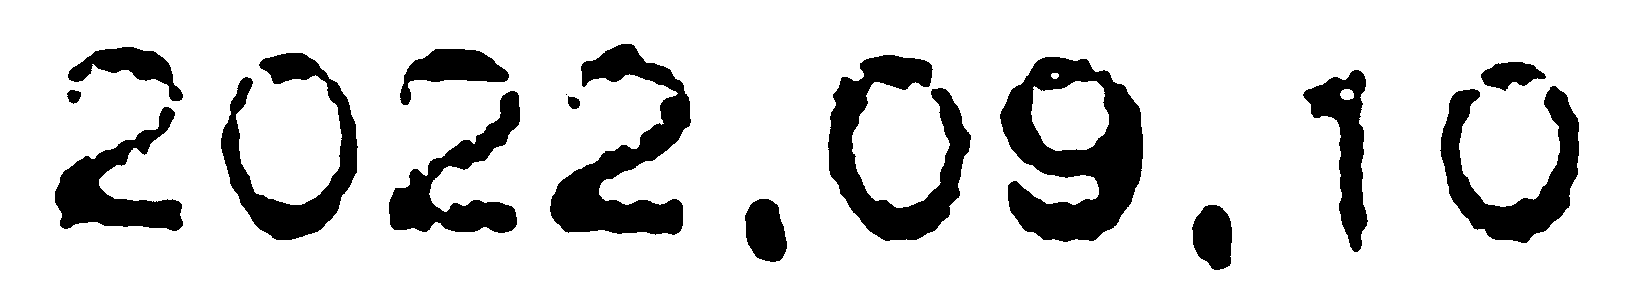

RESULT: '<022,09,10'

--- 4. Testing Morphological + Whitelist ---
Processed Image (This is the perfect image):


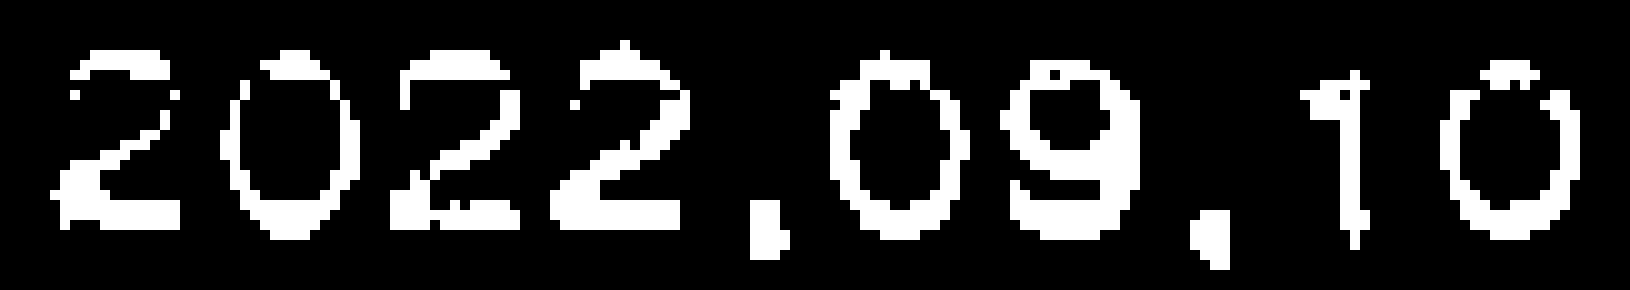

RESULT: '20220910'

--- 5. Testing Bilateral Filter (Edge-Preserving) ---
Processed Image (Bilateral Filter + Otsu):


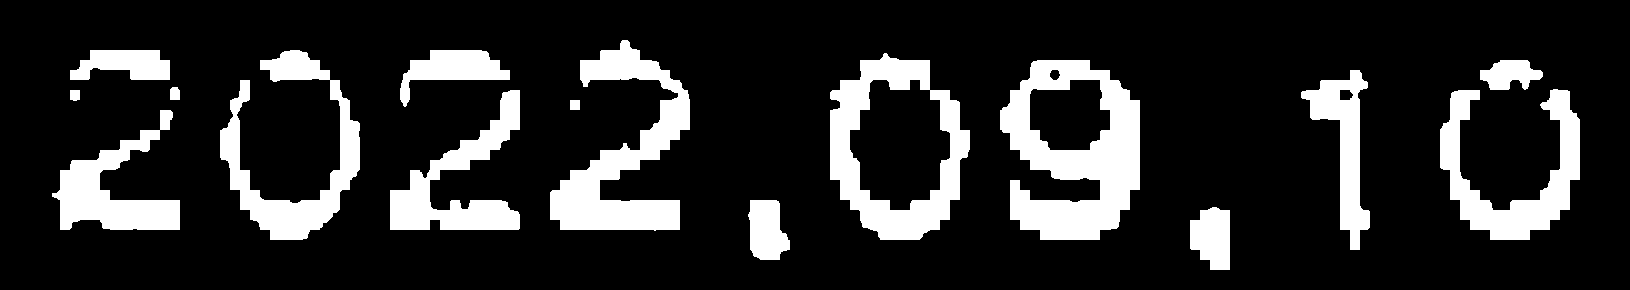

RESULT: 'L022,09,10'



In [ ]:
run_optimized_raw_ocr(IMAGE_PATH)
run_optimized_kmeans_ocr(IMAGE_PATH)
run_optimized_classic_ocr(IMAGE_PATH)
run_morphological_ocr(IMAGE_PATH)
run_adaptive_threshold_ocr(IMAGE_PATH)